# 8. Graphical Models

## 8.3. Markov Random Fields

In [1]:
def addNoise(image, num=50, binary=False):
    img = np.copy(image).ravel()
    idx = np.random.choice(img.size, size=num)
    if binary:
        img[idx] = np.array(~img[idx].astype(bool), dtype=int)
    else:
        img[idx] *= -1
    return img.reshape(*image.shape)

## 8.3.3 Illustration: Image de-noising (ICM algorithm)

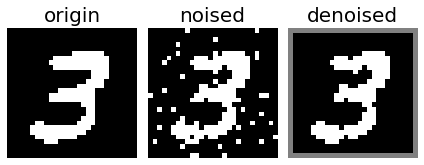

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from deepL_module.datasets.mnist import load_mnist
import itertools


def get_energy(loc): # calc. Hamiltonian
    delta = list(itertools.product(range(-1, 2), range(-1, 2)))
    Del = np.sum([X_out[tuple(idx)] for idx in np.array(loc) + delta])
    E = h * X_out.sum() - eta * (X_in * X_out).sum() - beta * Del * X_out[loc]
    return E


def ICM(loc):
    global X_out
    E = []
    X_out[loc] = 1
    E.append(get_energy(loc))
    X_out[loc] = -1
    E.append(get_energy(loc))
    X_out[loc] = 2 * np.argmax(E) - 1


#1 Preparing image data
(data, _), _ = load_mnist(normalize=True)
origin = np.where(data[7] > 0.5, 1, -1).reshape(28,28)
X_in = addNoise(origin)
X_out = X_in.copy()


#2 Setting Hamiltonian params
h = 0.2
beta = .5
eta = 2


''' #3 ICM algorithm '''
for _ in range(10):
    for loc in itertools.product(range(1, 27), range(1, 27)):
        ICM(loc)


#4 display images
padding = np.pad(np.ones((26, 26)), (1, 1), 'constant')
images = {'origin':origin, 'noised':X_in, 'denoised':X_out * padding}
for n, (text, disp) in enumerate(images.items()):
    ax = plt.subplot(1, 3, n+1)
    ax.imshow(disp, cmap='gray')
    ax.axis("off")
    plt.title(text, fontsize=20)
plt.tight_layout()
plt.show()

## 8.4.4 The sum-product algorithm

### Sum-product Algorithm (Belief Propagation)

- Repeat following step
<br>

 1. A message from a variable node $x_m$ to a factor node $f_s$ is the product of the messages from all other neighboring factor nodes (except recipent; If a leaf node is variable node, then the message is $\mu_{x\to f}(x)=1$) 
 <br><br>
 $$
 \begin{align*}
    \mu_{x_m\to f_s}(x_m)=\prod_{\ell \in \mathrm{ne}(x_m)\backslash f_s}\mu_{f_{\ell}\to x_m}(x_m)
 \end{align*}
 $$
<br><br>
 2. A message from a factor node $f_s$ to a variable node $x$ is the product of the factor with messages from all other nodes, marginalized over all variables except the one associated with $x$
 <br><br>
 $$
 \begin{align*}
    \mu_{f_s\to x}(x)=\sum_{x_1}\cdots \sum_{x_M}f_s(x,x_1,\cdots,x_M)\prod_{m\in \mathrm{ne}(f_s)\backslash x}\mu_{x_m\to f_s}(x_m)
 \end{align*}
 $$
 <br><br>
where $\mathrm{ne}(f_s)\backslash x$ denotes the set of factor nodes that are neighbours of $f_s$ with node $x$ removed
 <br><br>
 
 
 - After convergence 
 <br><br>
 The required marginal can be evaluated by following equation. 
 <br><br>
 $$
 \begin{align*}
 p(x)=\prod_{s\in \mathrm{ne}(x)}\mu_{f_s\to x}(x)
 \end{align*}
 $$

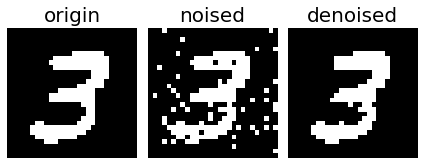

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from deepL_module.datasets.mnist import load_mnist
from graphx import *
import itertools


def generateMarkovNetwork(image):

    mrf = MarkovRandomField()
    for nodeID, _ in enumerate(itertools.product(range(x_len), range(y_len))):
            node = Node()
            mrf.add_node(nodeID, node)

    for n, (x,y) in enumerate(itertools.product(range(x_len), range(y_len))):
        node = mrf.get_node(n)
        for dx, dy in itertools.permutations(range(-1, 2), 2):
            try:
                neighbor = mrf.get_node(y_len * (x + dx) + y + dy)
                node.add_neighbor(neighbor)
            except Exception:
                pass

    return mrf


def removalNoise(noised_image):
    
    output = np.zeros_like(noised_image)
    
    for n, loc in enumerate(itertools.product(range(x_len), range(y_len))):
        node = network.get_node(n)
        output[loc] = np.argmax(node.prob)

    return output


#1 Preparing image data
(data, _), _ = load_mnist(normalize=True)
origin_image = (data[7] > .5).astype(int).reshape(28, 28)
noisy_image = addNoise(origin_image, binary=True)
x_len, y_len = origin_image.shape


#2 constructing Markov Random field
network = generateMarkovNetwork(origin_image)


#3 setting obeserved value
for n, loc in enumerate(itertools.product(range(x_len), range(y_len))):
    node = network.get_node(n)
    node.likelihood(noisy_image[loc])


''' #4 sum-product algorithm '''
network.message_passing(n_iter=10)


#5 image de-noising
output = removalNoise(noisy_image)

#6 display images
images = {'origin':origin_image, 'noised':noisy_image, 'denoised':output}
for n, (text, disp) in enumerate(images.items()):
    ax = plt.subplot(1, 3, n+1)
    ax.imshow(disp, cmap='gray')
    ax.axis("off")
    plt.title(text, fontsize=20)
plt.tight_layout()
plt.show()